# Tutorial on deploying neural networks for in-situ inference on frame grabber FPGAs in high-speed imaging.

Written by: Ryan Forelli

Last Modified: 8/7/2024

## Table of Contents
- Introduction
- Important info
    - Software requirements
    - Hardware requirements
    - Neural network requirements
    - Supported pixel formats
    - Camera acquisition requirements
    - Model results
- CustomLogic and board configuration
- Neural network preparation
    - Imports
    - Useful functions
    - Configure pretrained/quantized model
- Frame grabber reference design integration
    - Testbench data preparation
    - Merging HLS designs
        - defines.h
        - CustomLogic.h
        - myproject.cpp
        - nnet_helpers.h
- C-simulation and C-synthesis
- RTL simulation and implementation
- Bitstream deployment
- Hardware validation
- Latency benchmarking
- Conclusion

## Introduction

Many scientific domains utilize high-speed imaging to aid in experimentation and discovery. From analyzing fusion magneto hydrodynamics to crystal structure detection in transmission electron microscopy, there is a need for in-situ fast inference in these experiements which operate in the kHz to MHz range. Typically, a dedicated PCIe frame grabber device is paired with a high-speed camera to handle such high throughput, and a protocol such as CoaxPress is used to trasmit the raw camera data between the systems. Many frame grabbers implement this protocol as well additional pixel preprocessing stages on an FPGA device. Some manufacturers such as Euresys have enabled easy access to their FPGA firmware reference design. This refernce design, aptly named CustomLogic, allows the user to implement custom image processing functions on the available portion of their frame grabber's FPGA. Moreover, open-source codesign workflows like [hls4ml](https://fastmachinelearning.org/hls4ml/) enables easy translation and deployment of neural networks to FPGA devices, and have demonstrated latencies on the order of nanoseconds to microseconds with successful applications using standard FPGA accelerators to many domains including particle physics and material science. Here, we demonstrate the process of melding the CustomLogic and hls4ml workflows to yield a frame grabber neural network implementation, complete with C/RTL simulation tools and pre-written HDL to enable easy inference latency benchmarking. 

## Important info

### Software requirements
- Euresys Coaxlink CustomLogic package version 24.04.0.445.0 or later. Email Euresys at support.usa@euresys.com or your respective regions support email to receive the CustomLogic package download. At the time of this writing, it will be delivered as a zip file.
- eGrabber Studio version 24 or later. See [Euresys download area](https://www.euresys.com/en/Embedded-Vision-Software-Drivers-and-Documentation).
- AMD Xilinx Vivado 2022.2
- ```hls4ml_frame_grabber``` conda environment. See README for instructions on installing.
- hls4ml custom fork 0.8.1 (installed with conda environment)

### Hardware requirements
The included firmware reference design supports the following Euresys cameras
- 3602 Coaxlink **Octo**
- 3603 Coaxlink **Quad CXP-12**
- 3625 Coaxlink **QSFP+**

### Neural network requirements
- All ``io_stream`` architectures supported by hls4ml are supported by this reference design. However, your neural network output must also have a total size (in bits) less than the size of camera resolution size (in bits)

### Supported pixel formats
- The frame grabber reference design supports the following pixel formats. Be sure your model is trained on data captured in one of these formats on the camera you intend to deploy to for best results. 
  - Mono 8-bit
  - Mono 12-bit
  - Mono 16-bit

### Camera acquisition requirements
You must configure your camera acquisition to an image width that is a multiple of the values defined below. These values are set based on the desired pixel depth and firmware stream depth (128 bits on Octo, 256 bits on Quad CXP-12 and QSFP+).
- Octo (8-bit). Width must be multiple of **16**
- Octo (12-bit). Width must be multiple of **8**
- Octo (16-bit). Width must be multiple of **8**
- Quad CXP-12 (8-bit). Width must be multiple of **32**
- Quad CXP-12 (12-bit). Width must be multiple of **16**
- Quad CXP-12 (16-bit). Width must be multiple of **16**
- QSFP+ (8-bit). Width must be multiple of **32**
- QSFP+ (12-bit). Width must be multiple of **16**
- QSFP+ (16-bit). Width must be multiple of **16**

### Model results
There are two methods to retreive the neural network predictions from the frame grabber FPGA. This guide will utilize method 1.
1. Embed predictions in image. Using this method, model predictions are inserted and replace the first N bits of its corresponding input frame which is returned to host. As demonstrated later, a simple python script can extract these predictions. The limitation of this method is that a portion of the region of interest may be overwritten by the model output. Extracting and parsing model results by this method is far more scalable, but less suited to real-time control applications than method 2.
2. Write predictions serially over frame grabber TTL/RS422 IO. The frame grabbers feature [two 1MHz TTL general purpose IO](https://documentation.euresys.com/Products/Coaxlink/Coaxlink_10_5/en-us/Content/03_Using_Coaxlink/hardware-manual/meca/connectors/inst300-int-io1.htm?tocpath=Using%20Coaxlink%7CHardware%20Manual%7CMechanical%20Specification%7CConnectors%7C_____15) (or ten [10MHz RS422 IO](https://documentation.euresys.com/Products/Coaxlink/Coaxlink_10_5/en-us/Content/03_Using_Coaxlink/hardware-manual/elec/differential-io.htm) by way of [this](https://www.euresys.com/en/Products/Accessory/HD26F-I-O-Extension-Module-TTL-CMOS5V-RS422) extension module). This method is more suited to real-time applications where the frame grabber must communicate with a downstream system. Example code for outputting model results serially is included in ``04_ref_design/result_writeout.v``. This verilog can be customized to output your models predictions. Note that the module instantiation is currently commented out in the top-level HDL file (CustomLogic.vhd).


----------------
<!-- ### Before you begin!
Before we begin merging your neural network with the frame grabber reference design. We must determine the order of the CoaxPress output to the frame grabber, as this determines the pixel input order to your model. For example, the Phantom S710, which this tutorial targets, outputs a stream of data from the camera sensor which is in unnaturally ordered (see image stitching process in the [S710 manual](https://www.phantomhighspeed.com/-/media/project/ameteksxa/visionresearch/documents/datasheets/web/wdss710.pdf?download=1)). Normally, the frame grabber reorders the image data stream to represent the natural pixel order of the image. However, this processing block sits **after** our neural network custom logic in the functional diagram (see DMA block [here](https://documentation.euresys.com/Products/COAXLINK/COAXLINK_16_0/en-us/Content/11_Pdf/D209ET-Coaxlink_CustomLogic_User_Guide-eGrabber-16.0.2.2128.pdf#page=7)). Therefore, we must perform this "stripe reordering" operation manually. -->



<!-- First we must determine what the order of the raw CoaxPress image data. This information can sometimes be found in your cameras technical manual. However, in case it is not, a dedicated reference design is included which will allow you to empirically determine this order. The reference design hardcodes a gradient of pixel values from 0 to 2^n where n is your selected pixel depth. For example, the following gradient was harcoded to the custom logic output stream. (excluding sequence numbers)
![image.png](attachment:218568d8-5478-4c8a-b651-8b5170fe9180.png)

However, at the host, the following image was received (excluding sequence numbers)
![image.png](attachment:2778cffa-a08f-4766-8a9d-5f0a0eeebf8b.png)

As you can see image is split into 8 stripes and reorganized from the order [0,1,2,3,4,5,6,7] to the order [6,4,2,0,1,3,5,7]. Thus, we must perform the same operation in our firmware. This process is the most difficult of the work to come. First select the appropriate reference design from the list below. All designs are located in ./pattern_tests. The bit stream correspond to each version is in 06_release. Currently, these designs are configured to output a gradient with 128 at each pixel value. If it is difficult to interpret the stripe pattern of your camera at your desired resolution, try increasing or decresing the GRAD_NUM value in 05_ref_design_hls/CustomLogic.h. Note that depending on your desired image dimensions, the gradient may wrap around at some point in the image. Take note of the order of your stripes for later. Ours was [6,4,2,0,1,3,5,7].
 -->

## CustomLogic and board configuration

We will be targeting the Octo for this guide, so we will configure our template reference design for this board by copying over the necessary files from the stock CustomLogic package and providing a few of our own. For this step, **place your zipped CustomLogic package in the same directory as this repository. Change your target board and CustomLogic download destination directory in the cell below if needed.**  

**Important**: Custom versions of the stock ```CustomLogic.vhd```, ```create_vivado_project.tcl```, and ```customlogic_functions.tcl``` files are used for this tutorial and are stored in this repository. Future updates to CustomLogic may render these files obsolete. In this case, **do not** contact Euresys for support. Instead, feel free to contact the email at the end of notebook for support.  

In [1]:
BOARD = "octo" # Insert board name here ("octo" or "quad" or "qsfp")
CUSTOMLOGIC_DOWNLOAD_DIR = ".." # Place your CustomLogic zip download in the same directory as this repository.
FRAME_GRABBER_DIR = "my-frame-grabber_TEMPLATE_MNIST"

In [2]:
import os
import shutil
import glob

# Check for CustomLogic downloads
customlogic_files = glob.glob(f"{CUSTOMLOGIC_DOWNLOAD_DIR}/coaxlink-customlogic-*.zip")
if not customlogic_files:
    raise FileNotFoundError("Error: No CustomLogic downloads found")
else:
    valid_files = []
    for file in customlogic_files:
        base_name = os.path.basename(file)
        version_no = base_name[len("coaxlink-customlogic-"):].split('.')[0] 

        # Check version number
        if version_no.isdigit() and int(version_no) >= 24:
            valid_files.append(file)

    if len(valid_files) > 1:
        raise ValueError("Error: More than one CustomLogic download found. Please ensure only one CustomLogic download exists in the target directory.")    
    elif not valid_files:
        raise ValueError("Error: Your CustomLogic download is too old or another error occurred. Ensure you have CustomLogic version 24 or higher.")

In [3]:
!unzip -o {valid_files[0]} -d ..

Archive:  ../coaxlink-customlogic-24.04.0.445.0.zip
  inflating: ../CustomLogic/CoaxlinkOcto_1cam/01_readme/README.txt  
  inflating: ../CustomLogic/CoaxlinkOcto_1cam/02_coaxlink/constr/Bitstream_settings.xdc  
  inflating: ../CustomLogic/CoaxlinkOcto_1cam/02_coaxlink/constr/CxlOcto_loc_common.xdc  
  inflating: ../CustomLogic/CoaxlinkOcto_1cam/02_coaxlink/constr/CxlOcto_timing_common.xdc  
  inflating: ../CustomLogic/CoaxlinkOcto_1cam/02_coaxlink/constr/CxlOcto_xil_x8_gen3.xdc  
  inflating: ../CustomLogic/CoaxlinkOcto_1cam/02_coaxlink/dcp/CoaxlinkDcp.dcp  
  inflating: ../CustomLogic/CoaxlinkOcto_1cam/02_coaxlink/hdl_enc/CustomLogicPkt.vhdp  
  inflating: ../CustomLogic/CoaxlinkOcto_1cam/02_coaxlink/hdl_enc/CustomLogicPkt.vp  
  inflating: ../CustomLogic/CoaxlinkOcto_1cam/02_coaxlink/hdl_enc/CustomLogicTopPkt.vhdp  
  inflating: ../CustomLogic/CoaxlinkOcto_1cam/02_coaxlink/ips/axis_data_fifo.xcix  
  inflating: ../CustomLogic/CoaxlinkOcto_1cam/02_coaxlink/ips/axi_dwidth_clk_converter

In [4]:
if BOARD.lower() not in ["octo", "quad", "qsfp"]:
    raise ValueError("Error: please specify one of the following boards: \"octo\", \"quad\", \"qsfp\"")
else:
    os.makedirs(FRAME_GRABBER_DIR, exist_ok=True)
    
    shutil.copytree(f"../CustomLogic/Coaxlink{BOARD[0].upper() + BOARD[1:] if BOARD else BOARD}_1cam/01_readme", f"{FRAME_GRABBER_DIR}/01_readme", dirs_exist_ok=True)
    shutil.copytree(f"../CustomLogic/Coaxlink{BOARD[0].upper() + BOARD[1:] if BOARD else BOARD}_1cam/02_coaxlink", f"{FRAME_GRABBER_DIR}/02_coaxlink", dirs_exist_ok=True)
    shutil.copytree(f"../CustomLogic/Coaxlink{BOARD[0].upper() + BOARD[1:] if BOARD else BOARD}_1cam/03_scripts", f"{FRAME_GRABBER_DIR}/03_scripts", dirs_exist_ok=True)
    shutil.copytree(f"../CustomLogic/Coaxlink{BOARD[0].upper() + BOARD[1:] if BOARD else BOARD}_1cam/04_ref_design", f"{FRAME_GRABBER_DIR}/04_ref_design", dirs_exist_ok=True)
    shutil.copytree(f"../CustomLogic/Coaxlink{BOARD[0].upper() + BOARD[1:] if BOARD else BOARD}_1cam/06_release", f"{FRAME_GRABBER_DIR}/06_release", dirs_exist_ok=True)

    shutil.copy(f"board_files/{BOARD.lower()}/run_impl.tcl", f"{FRAME_GRABBER_DIR}/03_scripts")
    shutil.copy(f"board_files/{BOARD.lower()}/create_vivado_project.tcl", f"{FRAME_GRABBER_DIR}/03_scripts")
    shutil.copy(f"board_files/customlogic_functions.tcl", f"{FRAME_GRABBER_DIR}/03_scripts")

    shutil.copy(f"board_files/CustomLogic.vhd", f"{FRAME_GRABBER_DIR}/04_ref_design")
    shutil.copy(f"board_files/myproject_axi_wrp.vhd", f"{FRAME_GRABBER_DIR}/04_ref_design")
    shutil.copy(f"board_files/result_writeout.v", f"{FRAME_GRABBER_DIR}/04_ref_design")
    shutil.copy(f"board_files/signal_inference.v", f"{FRAME_GRABBER_DIR}/04_ref_design")

    shutil.copytree(f"board_files/05_model_design_hls", f"{FRAME_GRABBER_DIR}/05_model_design_hls", dirs_exist_ok=True)
    shutil.copy(f"board_files/{BOARD.lower()}/CustomLogic.h", f"{FRAME_GRABBER_DIR}/05_model_design_hls/srcs")

## Neural network preparation

Note that you must have a fully compiled (not synthesized) HLS model, generated by hls4ml, to proceed to the next steps. For this tutorial. If you do not have your own model, you can follow along below to compile the MNIST example model from hls4ml's [example-models](https://github.com/fastmachinelearning/example-models/tree/ff74f73dbc253d1aa7de1603ee10ede551919548) repository. First lets just import a few packages and define some functions we will need later.

### Imports

In [5]:
import hls4ml
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import qkeras
import numpy as np
from keras.models import model_from_json
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
import numpy as np
import os

2024-08-06 19:25:09.563301: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/xilinx/xrt/lib
2024-08-06 19:25:09.563333: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Useful functions

In [6]:
def print_dict(d, indent=0):
    align = 20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))  

In [7]:
def pad_images(images, pad_value=0, start_x=0, start_y=0, target_width=128, target_height=32):
    num_images, img_height, img_width = images.shape

    # Create an array to hold the padded images
    padded_images = np.full((num_images, target_height, target_width), pad_value, dtype=images.dtype)

    # Iterate through each image and place it within the padded array
    for i in range(num_images):
        # Calculate the end positions
        end_x = min(start_x + img_width, target_width)
        end_y = min(start_y + img_height, target_height)

        # Place the image within the padded array
        padded_images[i, start_y:end_y, start_x:end_x] = images[i, :end_y - start_y, :end_x - start_x]

    return padded_images

## Configure pretrained/quantized model

As mentioned above, for this demonstration we will implement the pretrained quantized MNIST CNN example available from the hls4ml package. See [here](https://github.com/fastmachinelearning/hls4ml-tutorial) for tutorials on how to perform quantization aware training and how to convert your CNN to an HLS model using hls4ml. The example model here already has a defined hls4ml config.

Take note of the output bitwidth of this model. It looks like this MNIST model output contains 16-bit values. Note that the specified FPGA part does not matter in this case.

Now lets load the CNN so we can see the architecture.
It looks like the model takes 28x28 monochrome images as input and outputs ten 16-bit label values. So note that the total bit width of the packed CNN output is 10 * 16 bits = 160 bits. This falls under our 28 * 28 * 8 = 6272 bit limit on the model output size.

In [8]:
hls4ml.utils.fetch_example_model('qkeras_mnist_cnn.json') # Import example CNN
json_file = open('qkeras_mnist_cnn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json, custom_objects={'quantized_relu': qkeras.quantized_relu, 'QActivation': qkeras.QActivation, 'QDense': qkeras.QDense, 'QConv2D': qkeras.QConv2D})
loaded_model.load_weights('qkeras_mnist_cnn_weights.h5')

# Input is 28x28
loaded_model.summary()

2024-08-06 19:25:12.265325: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-08-06 19:25:12.265352: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gw001): /proc/driver/nvidia/version does not exist
2024-08-06 19:25:12.265585: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_conv2d (QConv2D)          (None, 26, 26, 16)        160       
                                                                 
 q_activation (QActivation)  (None, 26, 26, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 q_conv2d_1 (QConv2D)        (None, 11, 11, 16)        2320      
                                                                 
 q_activation_1 (QActivation  (None, 11, 11, 16)       0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0

In [9]:
io_type = 'io_stream'
backend = 'Vitis'
part = 'xcku035-fbva676-2-e'
OUT_DIR = f'my-hls-test'

config = hls4ml.utils.config_from_keras_model (loaded_model,
                                                   default_precision = 'ap_fixed<16,6>',
                                                   granularity = 'name') # Import example CNN

config["LayerName"]["q_conv2d"]["ReuseFactor"] = 36
config["LayerName"]["q_conv2d"]["Strategy"] = "Resource"

config["LayerName"]["q_conv2d_1"]["ReuseFactor"] = 288
config["LayerName"]["q_conv2d_1"]["Strategy"] = "Resource"

config["LayerName"]["q_dense"]["ReuseFactor"] = 4000
config["LayerName"]["q_dense"]["Strategy"] = "Resource"

print_dict(config)

Interpreting Sequential
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 16]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 26, 26, 16]], output shape: [None, 26, 26, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 16]], output shape: [None, 13, 13, 16]
Layer name: q_conv2d_1, layer type: QConv2D, input shapes: [[None, 13, 13, 16]], output shape: [None, 11, 11, 16]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 11, 11, 16]], output shape: [None, 11, 11, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 11, 11, 16]], output shape: [None, 5, 5, 16]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 5, 5, 16]], output shape: [None, 400]
Layer name: q_dense, layer type: QDense, in

Now lets compile the hls model, this will generate an HLS project called "my-hls-test" in the current directory

In [10]:
hls_model = hls4ml.converters.convert_from_keras_model(loaded_model,
                                                       hls_config = config,
                                                       io_type = io_type,
                                                       backend = backend,
                                                       output_dir = OUT_DIR,
                                                       part = part
                                                       )

hls_model.compile()

Interpreting Sequential
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 16]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 26, 26, 16]], output shape: [None, 26, 26, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 16]], output shape: [None, 13, 13, 16]
Layer name: q_conv2d_1, layer type: QConv2D, input shapes: [[None, 13, 13, 16]], output shape: [None, 11, 11, 16]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 11, 11, 16]], output shape: [None, 11, 11, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 11, 11, 16]], output shape: [None, 5, 5, 16]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 5, 5, 16]], output shape: [None, 400]
Layer name: q_dense, layer type: QDense, in

Done


Looking at a sample model output, we can see an HLS model output value of 7.99902344 corresponds to a true value.

In [11]:
hls_model.predict(np.full((1, 28, 28), 7).astype(float))

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

## Frame grabber reference design integration

Now we can begin merging the model in the frame grabber reference design. Once we implement the neural network in the frame grabber firmware, we will need to validate the c-simulation and RTL simulation results with the HLS model results produced in Python. So lets obtain some predicted labels and verify the HLS model's accuracy is in the range we expect (about 98.83%). We know the data streaming to the frame grabber will be 8-bit unsigned, so we cast our dataset to uint8.

In [12]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Rescale pixel values to 0-255 range
train_images = train_images.astype('uint8')
test_images = test_images.astype('uint8')

# Make predictions on the test set
predictions = hls_model.predict(test_images/255.0)

# Calculate accuracy
predicted_labels = np.argmax(predictions, axis=1)

accuracy = np.mean(predicted_labels == test_labels)
print(f'Test accuracy: {accuracy * 100:.2f}%')

Test accuracy: 98.83%


### Testbench data preparation

Now we need to prepare the C/RTL testbench data for export to the reference design.

In [13]:
test_images.shape

(10000, 28, 28)

We can see the test dataset is 10000 images. Simulation would take a while on a data set of that size so lets grab a subset of 10 images.

In [14]:
test_images_subset = test_images[0:10]
predictions_subset = predictions[0:10]

As previously mentioned, this tutorial targets the Phantom S710 camera. The camera hardware limits us to a minimum resolution of 128x16. This must be taken into account when training your model. Ensure that you have recorded your training dataset on the same camera to which your deploying and that you have identified your models region of interest (if applicable). In our case, we will be setting a resolution of 128x32 on our camera to give us enough area for our ROI of 28x28.

Below, we will pad our MNIST data since this dataset was not actually captured at a resolution of 128x32. Below we will also specify where in the image our ROI will sit. Again, this will depend on your application. We will center the image. Keep note of this position as we will have to enter these same parameters in the frame grabber reference design later.

Shape of padded images: (10, 32, 128)


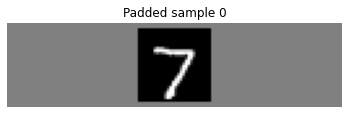

In [15]:
CROP_START_X = 50
CROP_START_Y = 2
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 128
# TAKE NOTE OF THESE ^^^

PAD_VAL = 128

# Pad the images to 128x32 with specified values and positions
test_images_subset_padded = pad_images(test_images_subset, pad_value=PAD_VAL, start_x=CROP_START_X, start_y=CROP_START_Y, target_width=IMAGE_WIDTH, target_height=IMAGE_HEIGHT)

# Check the shape of the padded images
print("Shape of padded images:", test_images_subset_padded.shape)

plt.imshow(test_images_subset_padded[0], cmap='gray')
plt.axis('off')
plt.title('Padded sample 0')
plt.show()


Now, we will export our testbench data to space deliminated data files. One input/output should occupy every line for the testbench to interpret the data correctly. Data is saved in raw uint8 format since the frame grabber firmware will be normalizing the data.

In [16]:
# Save input data
np.savetxt(f"{FRAME_GRABBER_DIR}/05_model_design_hls/tb_data/tb_input_features.dat", test_images_subset_padded.reshape(test_images_subset_padded.shape[0],-1), delimiter=' ', fmt='%d')

# Save output predictions
np.savetxt(f"{FRAME_GRABBER_DIR}/05_model_design_hls/tb_data/tb_output_predictions.dat", predictions_subset.reshape(predictions_subset.shape[0],-1), delimiter=' ', fmt='%.6f')

### Merging HLS designs

Now we will begin the task of merging the necessary code from the hls project generated by hls4ml (``my-hls-test``) into the template frame grabber reference design (``my-frame-grabber-test_TEMPLATE``). Most of our work will be done in ``05_model_design_hls/srcs``.

First we can copy the model type definitions, layer parameters, weights, layer templates, and arbitrary precision types over.

In [17]:
!cp -r {OUT_DIR}/firmware/nnet_utils/ {OUT_DIR}/firmware/weights {OUT_DIR}/firmware/parameters.h {OUT_DIR}/firmware/defines.h {FRAME_GRABBER_DIR}/05_model_design_hls/srcs


#### defines.h


Lets start with ``defines.h`` (in ``my-frame-grabber-test_TEMPLATE``, NOT ``my-hls-test``). We will be using definitions from the file CustomLogic.h so lets add ```#include "CustomLogic.h"``` in the header



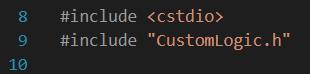

Next, we know that the frame grabber transfers 256 bits at a time (or 128 in the case of the Octo). This means in 8-bit mode, our custom logic will receive a pack of 256/8=32 pixels at a time. So we need a data type which can hold 32 model inputs. We can simply copy the ``input_t`` type defined by hls4ml, and set the array size to ``MONOPIX_NBR`` (which is 32). We will call the type ``input_arr_t``. 

After adding ```typedef nnet::array<input_t::value_type, MONOPIX_NBR> input_arr_t;```, we are done with defines.h.


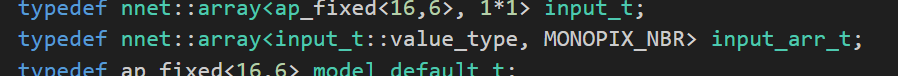

#### CustomLogic.h

Next, we will refer to CustomLogic.h. The first macro defines a divisor for normalization of your input data. By default, the firmware normalizes the input data with a division of 255 to a range of [0,1]. To change how the data is normalized, modify the ```Process_pixel``` loop of ```read_pixel_data()``` in myproject.cpp.



Next, we want to set the parameters for our camera aquisition. For this tutorial, this value and a few others will be the same as those defined in the testbench data preparation section. These values are defined below.

- ``PIXEL_FORMAT``: Specify your pixel format. Valid values are 8 or 16. If you are recording in 12-bit, write 16 here.
- ``NORM_DIV``: Divide your model's input data by this value for normailzation. In this example we will divide by 255 because we will be recording in Mono8 format.
- ``IMAGE_WIDTH``: Acuisition image width. Remember, ``IMAGE_WIDTH`` must be a multiple of 32.
- ``IMAGE_HEIGHT``: Acuisition image height.
- ``CROP_START_X``: If you would like to crop the image input to a specific ROI, specify the start x coordinate here. If you do not wish to crop an ROI, set this to 0.
- ``CROP_START_Y``: Specify the crop start y coordinate here. If you do not wish to crop an ROI, set this to 0.
- ``CROP_WIDTH``: Specify the crop width. If you do not wish to crop an ROI, set this equal to the IMAGE_WIDTH.
- ``CROP_HEIGHT``: Specify the crop height. If you do not wish to crop an ROI, set this equal to the IMAGE_HEIGHT.
- ``BLOCK_HEIGHT``: This parameter must be copied from the eGrabber interface. It will be auto-populated and can be found under Data Stream > StreamControl > BlockHeight. Enter it here.

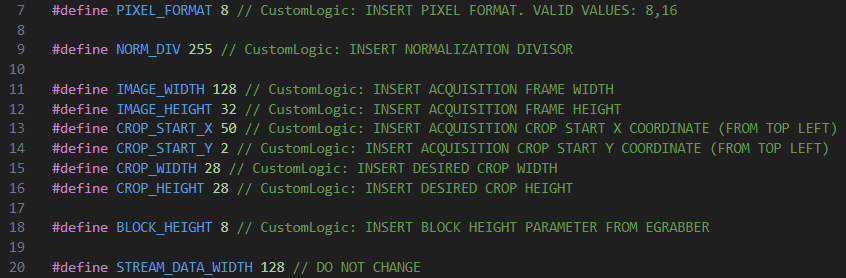

Now, at the bottom of ``CustomLogic.h`` we must enter the striping pattern which the frame grabber will receive out of the camera so the firmware can reoder the data before streaming into the model. Normally, the frame grabber reorders the image data stream to represent the natural pixel order of the image. However, this processing block sits **after** our neural network custom logic in the functional diagram (see DMA block [here](https://documentation.euresys.com/Products/COAXLINK/COAXLINK_16_0/en-us/Content/11_Pdf/D209ET-Coaxlink_CustomLogic_User_Guide-eGrabber-16.0.2.2128.pdf#page=7)). Therefore, we must perform this "stripe reordering" operation manually. Run the cell below to calculate the correct order. You will need to provide your image height and block height.

In [18]:
IMAGE_HEIGHT = 32
BLOCK_HEIGHT = 8

def gen_stripe_pattern(NUM_STRIPES):
    if NUM_STRIPES % 2 != 0:
        print("NUM_STRIPES must be even")
        return None
    
    stripe_order = []
    for i in range(NUM_STRIPES):
        if i % 2 == 0:
            stripe_order.append(((NUM_STRIPES // 2) - (i // 2)) - 1)
        else:
            stripe_order.append(((NUM_STRIPES // 2) + ((i + 1) // 2)) - 1)
    
    return stripe_order

NUM_STRIPES = IMAGE_HEIGHT/(BLOCK_HEIGHT/2)
stripe_order = str(gen_stripe_pattern(int(NUM_STRIPES))).replace('[', '{').replace(']', '}')
print("Copy this array to the stripe_order constant in CustomLogic.h: ", stripe_order)

Copy this array to the stripe_order constant in CustomLogic.h:  {3, 4, 2, 5, 1, 6, 0, 7}


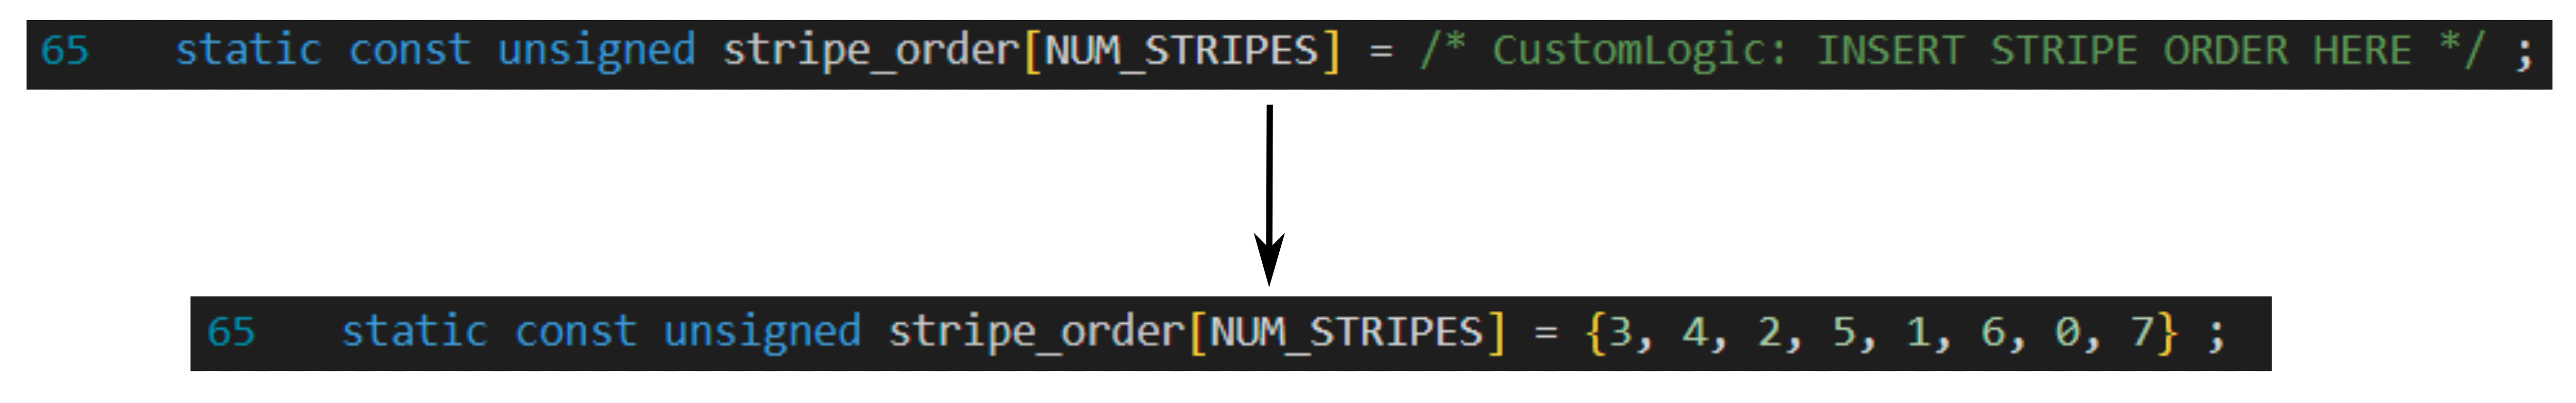

#### myproject.cpp

Next we will move our attention to ``myproject.cpp``. Specifically, we will be looking at the top-level function ``myproject()``. We will be inserting code between the forwardslash comment page breaks in the positions indicated with ``/* CustomLogic: ... */``. Firstly, we will notice multiple HLS streams and functions already in ``myproject()``. ``input_arr_split_reordered`` and ``VideoBuffer`` hold copies of the data that comes into the CustomLogic block. ``read_pixel_data()`` streams the incoming image data into the ``input_arr_split_reordered`` (transformed to natural order for model input) and ``VideoBuffer`` streams. These streams are sized to hold the entire incoming image. ``unpack_data()`` unpacks the the image data into individual pixels which the neural network takes as input. Note that this function only unpacks data which comprises the input to the model in order to save cycles and reduce streaming latency. In this case, packets of 32 pixels are unpacked and streamed into the model. The last function, ``attach_results()``, inserts the model results at the beginning of the image. As previously mentioned, the total size of the packed model results must be less than the image size in bits. 


The first variable we must populate is ``MODEL_OUT_DEPTH``. This variable will hold the depth of your model output stream. This value is not explicity assigned to any variable that hls4ml writes to the project. However, ``defines.h`` may define this value as a macro. Many hls4ml models will have an output size of 1, but this value depends on the shape of your model output when it was constructed in Python. It will be the product of the highest n-1 dimensions of the model's output shape. In this case, the output stream depth is 1, as the model outputs a single ``nnet::array`` sample with ten class values.

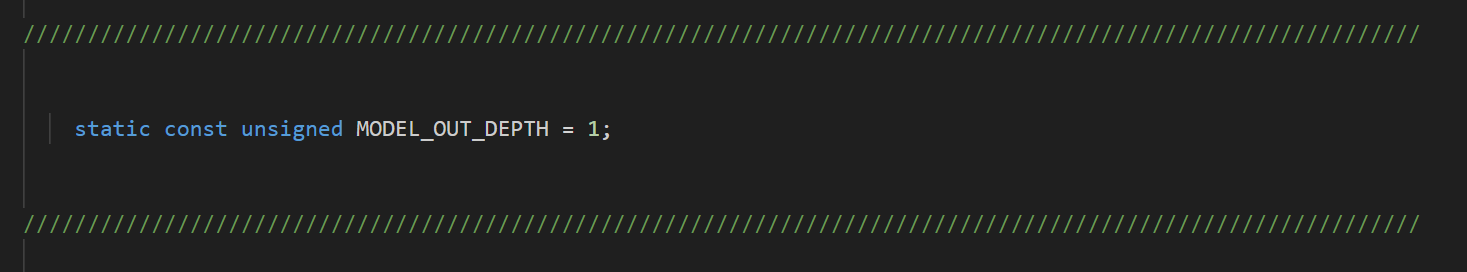

The first piece of code we want to copy over from ``my-hls-test``'s myproject.cpp to ``my-frame-grabber-test_TEMPLATE``'s ``myproject.cpp`` is the ``#ifndef`` block which loads the model weights from text files for C-simulation.
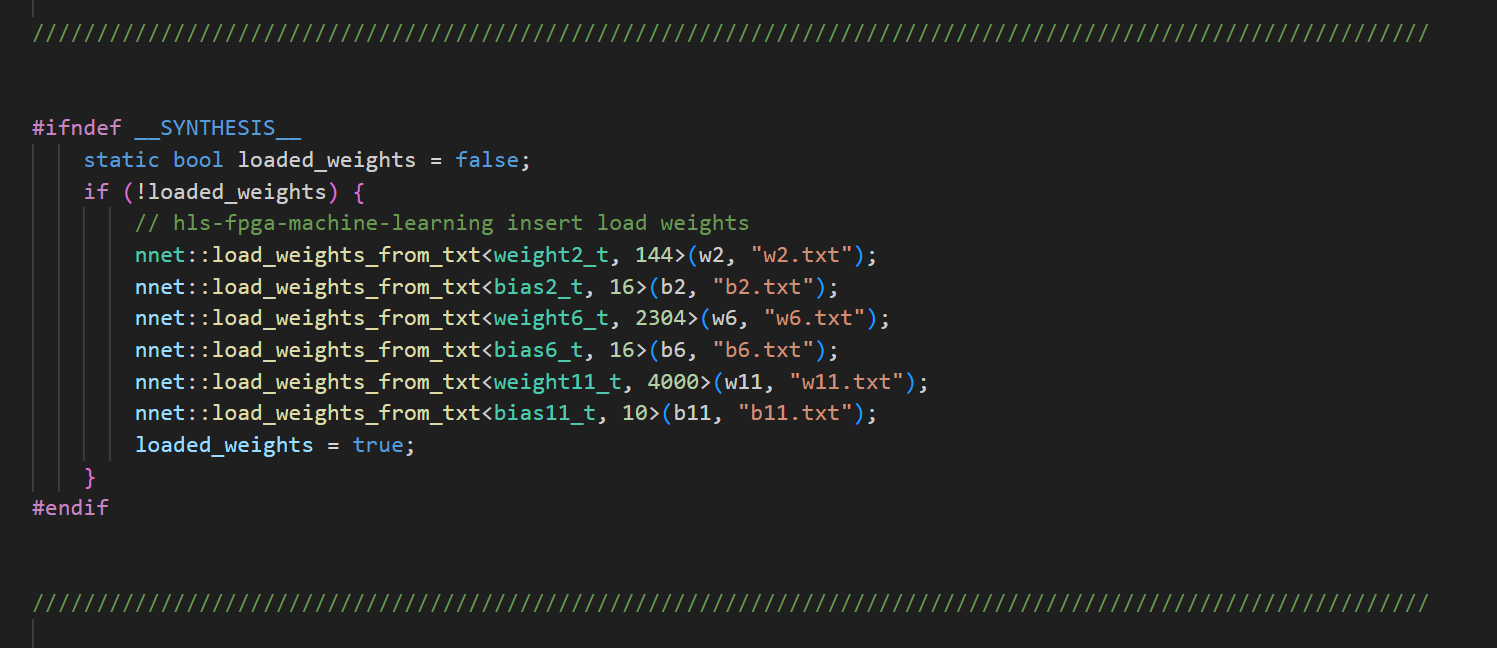

Next, we need to set the appropriate depths of the intermediate frame buffer ``input_arr_split_reordered``. Unfortunately, there is no way to use a loop structure to apply pragmas in Vitis HLS 2022.2. Instead, simply run the cell below to generate the HLS and insert it at the position indicated by the comment ``CustomLogic: INSESRT NETWORK SPLIT ARRAY HLS STREAM PRAGMAS HERE (from jupyter notebook)``

In [16]:
def generate_pragma_lines(NUM_STRIPES):
    for i in range(NUM_STRIPES):
        print(f'    #pragma HLS STREAM variable=input_arr_split_reordered[{i}] depth=PACKETS_PER_STRIPE')

generate_pragma_lines(int(NUM_STRIPES))  # This will generate 5 lines with incremented indices.


print("\n\nCopy the above HLS to myproject.cpp in the appropriate location")

    #pragma HLS STREAM variable=input_arr_split_reordered[0] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[1] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[2] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[3] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[4] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[5] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[6] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[7] depth=PACKETS_PER_STRIPE


Copy the above HLS to myproject.cpp in the appropriate location


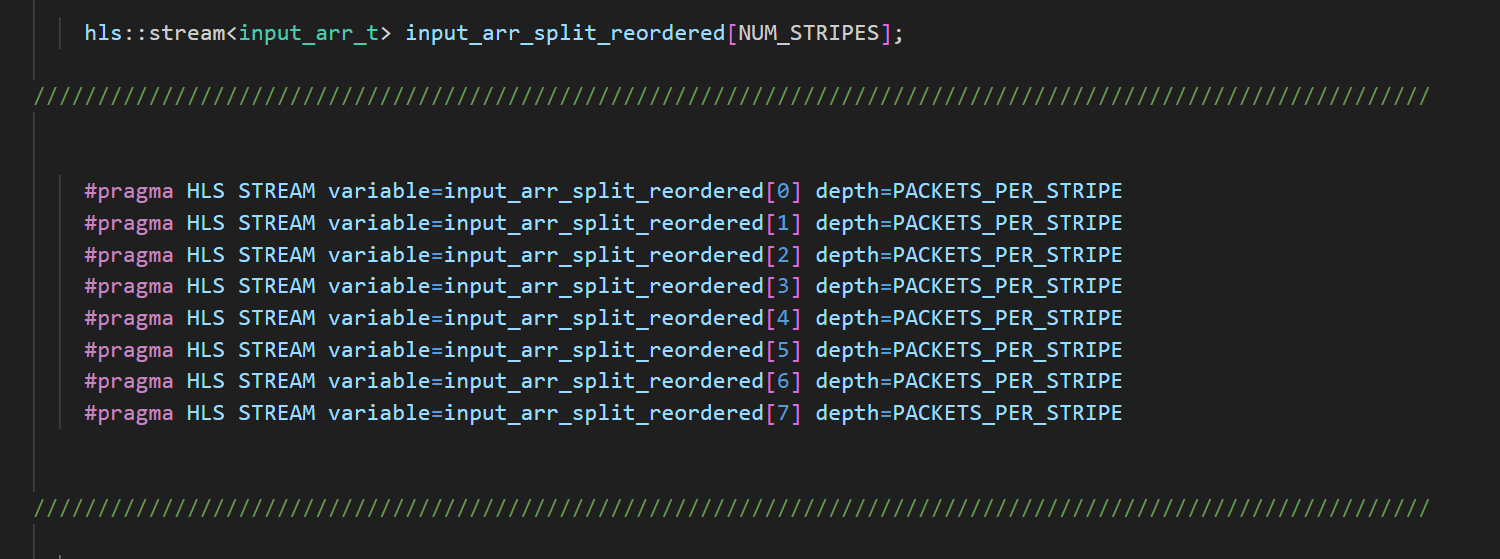


Next, we want to copy over the actual neural network layers.
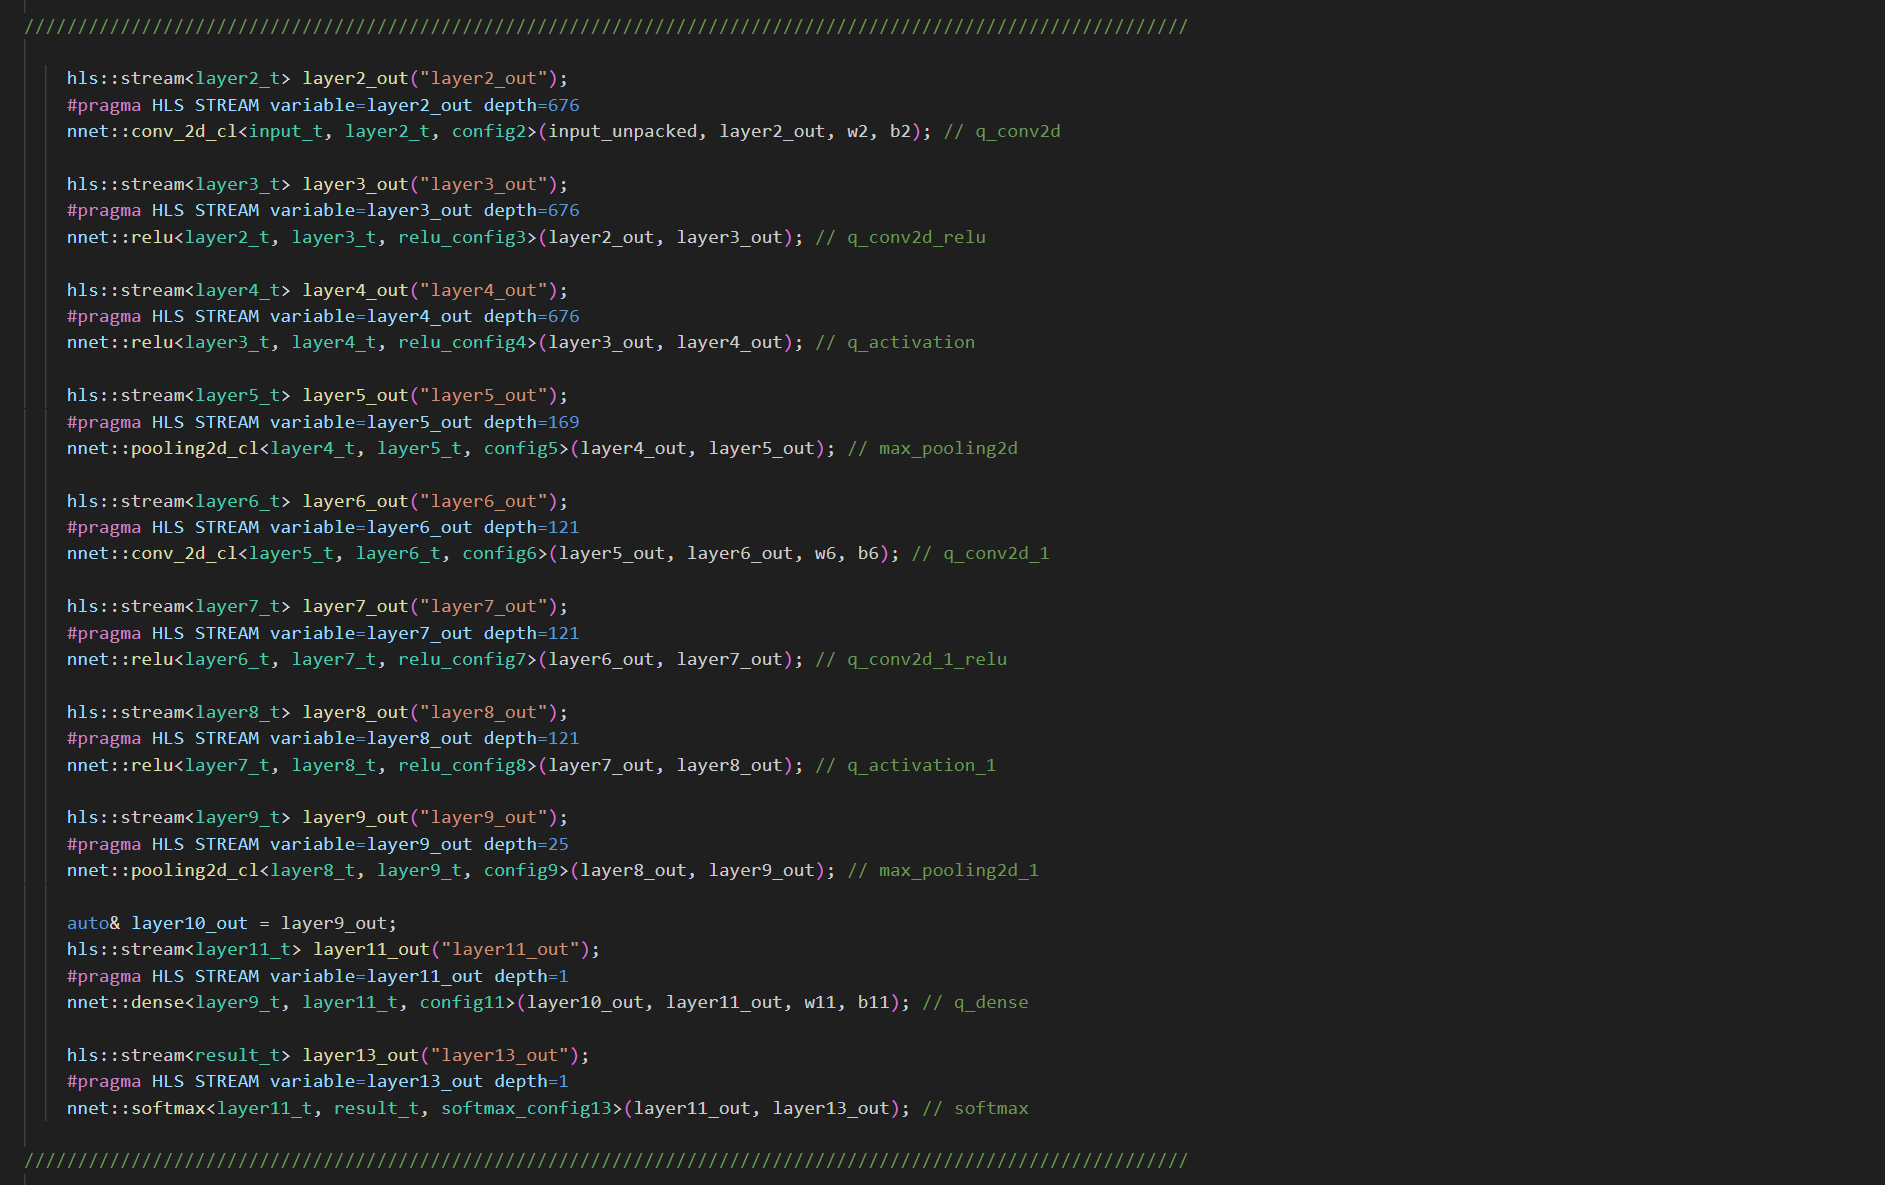


Lastly, we will need to change the name of the model output stream (``layer13_out`` in this case) to ``layerfinal_out``. Your model output stream should be the last stream argument of your networks final layer. ``attach_results()`` will then insert the neural network predictions at the beginning of the image.

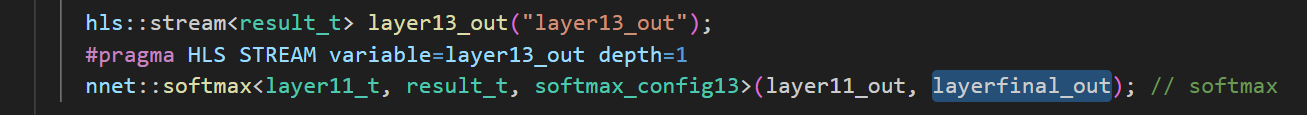

#### nnet_helpers.h

The final required modifcation to the firmware involes modifying the file ``nnet_utils/nnet_helpers.h``. Change the value of the ``WEIGHTS_DIR`` macro to ``../../../../srcs/weights``.


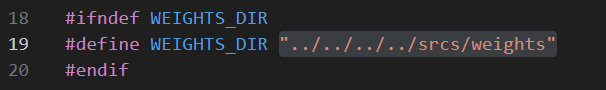

## C-simulation and C-synthesis

Now that we have added our testbench data and added our neural network to the frame grabber firmware, we can execute c-simulation to validate our firmware with the predictions we produced in Python using the HLS model. Recall that the Python HLS model predictions were placed in ``tb_data/tb_output_predictions.dat``. We can execute c-simulation by calling the tcl script named ``run_hls.tcl``. This script also executes c-synthesis. Run the following command in your terminal. Note that you can prepend ``nohup`` and append `` &`` to run c-simulation and c-synthesis in the background as it can take some time to complete.

In [20]:
!vitis_hls {FRAME_GRABBER_DIR}/05_model_design_hls/scripts/run_hls.tcl -f "csim=1 synth=1"


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2022.2 (64-bit)
  **** SW Build 3670227 on Oct 13 2022
  **** IP Build 3669848 on Fri Oct 14 08:30:02 MDT 2022
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx2/Vitis_HLS/2022.2/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx2/Vitis_HLS/2022.2/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'rff224' on host 'gw001' (Linux_x86_64 version 5.15.0-117-generic) on Tue Aug 06 19:30:26 EDT 2024
INFO: [HLS 200-10] On os Ubuntu 22.04.4 LTS
INFO: [HLS 200-10] In directory '/home/rff224/hls4ml-frame-grabbers_structured_pruning_v2/hls4ml-frame-grabbers'
Sourcing Tcl script 'my-frame-grabber-test_TEMPLATE/05_model_design_hls/scripts/run_hls.tcl'
INFO: [HLS 200-1510] Running: source my-frame-grabber-test_TEMPLATE/05_model_design_hls/scripts/run_hls.tcl
EURESYS_INFO: [Initial path] /home/rff224/hls4ml-frame-grabbers_structured_pruning_v2/hls4ml-frame-grabbers
EU

Once c-simulation and c-synthesis have completed, check ``tb_data/csim_results.log``. These values should match those in ``tb_data/tb_output_features.dat``. The "received image" comment in ``myproject_test.cpp`` can be uncommented to also display the received images along with the embedded predictions.

We can see our frame grabber CNN predictions match the HLS model's predictions from Python.

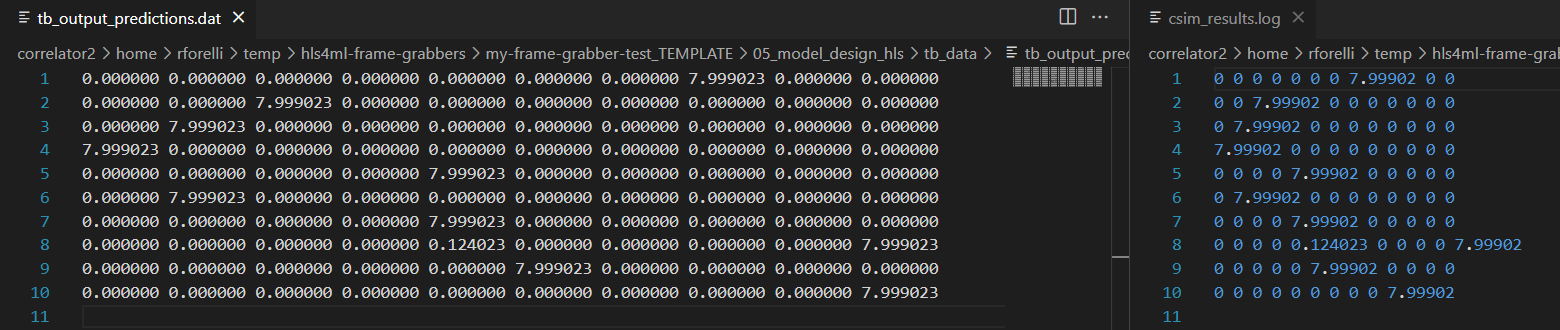

## RTL simulation and implementation

While c-simulation is a quick and easy way to make sure our algorithm is producing the expected results, our c-simulation does not simulate the model and camera protocol at the register transfer level. To further ensure our firmware behaves in hardware as expected, we can use the RTL testbench provided by Euresys. To configure the testbench, refer to ``04_ref_design/sim/SimulationCtrl_tb.vhd``. Here we will specify our acquisition resolution of 128x32 and pixel format of Mono8. See the command list in this file for more options.



To run the RTL simulation and begin the implementation process, run the following command in the frame grabber project directory (held in ```FRAME_GRABBER_DIR```) variable. Be sure to use Vivado 2022.2. 

```vivado -mode tcl -source 03_scripts/run_impl.tcl```

The testbench supplies a default input to the RTL simulation. For demonstration purposes, we will use this default input and supply the same input to our HLS model to make sure they match.

In [23]:
# Replicate default RTL testbench input
sequence = np.arange(50, 78)
array = np.tile(sequence, (28, 1)).reshape(1, 28, 28)

In [24]:
hls_model.predict(array.astype(float) / 255)

array([0.13378906, 0.23535156, 0.03808594, 0.02734375, 0.171875  ,
       0.03125   , 0.0859375 , 0.0625    , 0.16113281, 0.07128906])

Supplying the same input to the c-testbench, we can see the predictions match
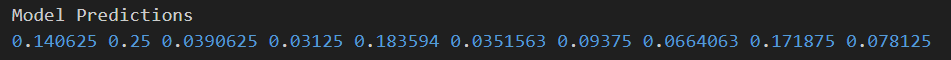

Looking at the end of the "received image" in the testbench, we can see the following sequence of numbers, representing the predictions shown above (but in a uint8 format). 
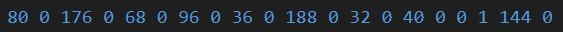

Now referring the "received image" from the RTL simulation, located in ``07_vivado_project/CustomLogic.sim/sim_1/behav/xsim/cl_output_data_ch0_000.dat``, we can see the same string of bytes at the tail of our image data (but represented in hexidecimal format).


## Bitstream deployment

Once your implementation completes, a bit stream should be generated and placed in ``/06_release`` named ``CoaxlinkOcto_1cam.bit``. Use the following steps to deploy your bistream to the frame grabber FPGA.

1. Open Euresys eGrabber Studio on the host PC.
2. Open the ``Firmware Manager``, select the ``Details`` tab, select ``File``, locate your bitstream
3. Select the ``Cards`` tabs, and install the firmware to your target.
4. One completed, completely power down your host PC (not restart) and reboot the machine.

## Hardware validation

Now we can validate the hardware implementation with our HLS model. Lets print the leading bytes of some frames we captured. Note that the camera was not looking at anything particularly interesting so they may look different from previous inferences.

In [3]:
N_BYTES = 20

def print_first_n_bytes_decimal(directory, n_bytes):
    # Read all .raw files in a sorted order to maintain sequence
    files = sorted([f for f in os.listdir(directory) if f.endswith('.raw') and f.startswith('image.')])
    
    # Process each file
    for file in files:
        filepath = os.path.join(directory, file)
        with open(filepath, 'rb') as file:
            raw_data = file.read(n_bytes)
            decimal_data = ' '.join(str(byte) for byte in raw_data)
            # Print byte data in decimal form
            print(f"{file.name}: {decimal_data}")

print_first_n_bytes_decimal('./images/MNIST', N_BYTES)

./images/MNIST/image.0.raw: 52 1 128 0 8 8 11 14 12 12 10 13 4 13 6 15 13 13 13 9
./images/MNIST/image.1.raw: 52 1 128 0 8 9 10 14 12 12 11 13 4 12 6 14 13 13 13 9
./images/MNIST/image.2.raw: 52 1 128 0 8 8 10 14 12 12 11 13 5 12 6 14 12 13 13 9
./images/MNIST/image.3.raw: 52 1 136 0 7 8 10 14 12 12 11 13 4 12 6 14 12 13 13 9
./images/MNIST/image.4.raw: 52 1 128 0 8 8 10 14 12 12 11 13 4 13 6 14 12 14 14 9
./images/MNIST/image.5.raw: 52 1 128 0 8 9 10 15 12 12 11 13 4 12 6 14 12 13 13 9
./images/MNIST/image.6.raw: 52 1 136 0 8 8 10 14 12 12 11 13 4 12 6 15 12 13 14 9
./images/MNIST/image.7.raw: 52 1 136 0 8 8 10 14 12 12 11 14 4 13 6 15 13 13 14 9
./images/MNIST/image.8.raw: 52 1 128 0 8 8 10 14 12 11 11 13 4 12 5 14 12 13 14 9
./images/MNIST/image.9.raw: 52 1 128 0 8 9 10 14 12 12 11 13 5 12 5 14 12 13 14 9


If we copy the captured frames to the HLS testbench and run c-simulation, we can compare frame 0 and verify the hardware is producing the results we would expect with this given input.



## Latency Benchmarking

Next, we want to benchmark our model in hardware. First, some configuration in the eGrabber acquisition software will be required to connect the ``UserOutput`` register to ``TTLIO11``.

1. In eGrabber Studio (or GenICam), locate the ``DigitalIOControl`` and ``LineSource`` sections
2. Assign ``TTLIO11`` to bit 0 of the user output register (``UserOutput0``)
3. Under the ``DigitalIOControl`` section, select ``TTLIO11`` in the ``LineSelector`` field
4. Set the ``LineMode`` to ``Output``
5. Under the ``LineSource`` section, select ``UserOutput0``

Now connect an oscilloscope or other digitizer to ``TTLIO11`` (pin 19 of  Internal I/0 1 Connector, see [here](https://documentation.euresys.com/Products/Coaxlink/Coaxlink_10_5/en-us/Content/03_Using_Coaxlink/hardware-manual/meca/connectors/inst300-int-io1.htm?tocpath=Using%20Coaxlink%7CHardware%20Manual%7CMechanical%20Specification%7CConnectors%7C_____15)).

Once you begin recording (try a low FPS to start), you should see a square wave, where the high-time denotes the model inference. We can see below, our model inference latency is ~200 us. More optimization is possible through the tunable reuse factor but runtimes will increase and be sure to monitor timing performance as you make these adjustments.


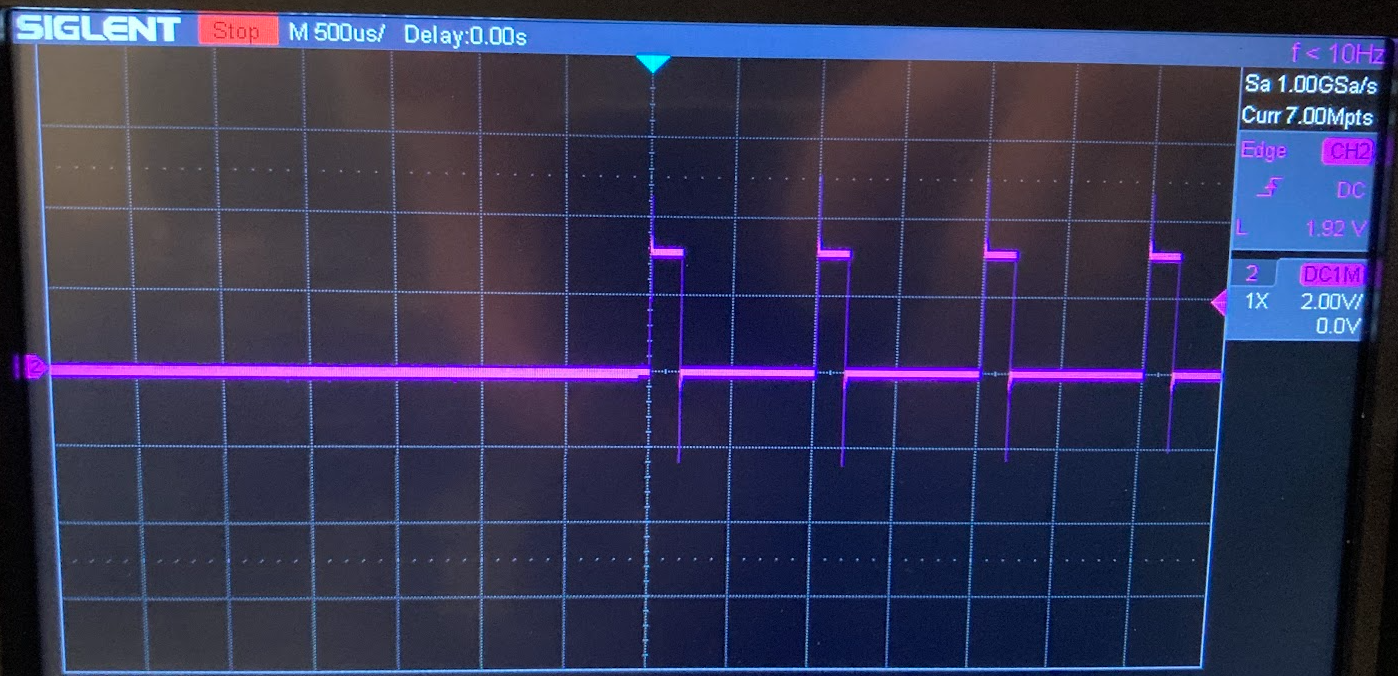

## Conclusion

Congratulations!! You have finished deploying a neural network your frame grabber's FPGA. Please feel free to reach out with feedback or questions at forelliryan@gmail.com.